**Submission Belajar Machine Learning Untuk Pemula**



*   **Nama** : Usriyatul Khamimah
*   **Domisili** : Cilacap, Jawa Tengah
*   **Surel**: khamimahusriyatul@gmail.com
*   **Beasiswa** :DBS Dicoding





In [ ]:
import tensorflow as tf
import requests
import zipfile
import os
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
url = 'https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip'
local_filename = 'rockpaperscissors.zip'

with requests.get(url, stream=True) as r:
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

with zipfile.ZipFile(local_filename, 'r') as zip_ref:
    zip_ref.extractall('data')


In [ ]:
base_dir = 'data/rockpaperscissors/rps-cv-images'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

make_dir(train_dir)
make_dir(validation_dir)

ROCK_SOURCE_DIR = os.path.join(base_dir, 'rock')
PAPER_SOURCE_DIR = os.path.join(base_dir, 'paper')
SCISSORS_SOURCE_DIR = os.path.join(base_dir, 'scissors')

TRAINING_ROCK_DIR = os.path.join(train_dir, 'rock')
TRAINING_PAPER_DIR = os.path.join(train_dir, 'paper')
TRAINING_SCISSORS_DIR = os.path.join(train_dir, 'scissors')

VALIDATION_ROCK_DIR = os.path.join(validation_dir, 'rock')
VALIDATION_PAPER_DIR = os.path.join(validation_dir, 'paper')
VALIDATION_SCISSORS_DIR = os.path.join(validation_dir, 'scissors')

make_dir(TRAINING_ROCK_DIR)
make_dir(TRAINING_PAPER_DIR)
make_dir(TRAINING_SCISSORS_DIR)

make_dir(VALIDATION_ROCK_DIR)
make_dir(VALIDATION_PAPER_DIR)
make_dir(VALIDATION_SCISSORS_DIR)


In [ ]:
BASE_DIR = 'data/rockpaperscissors/rps-cv-images'
TRAIN_DIR = 'data/rockpaperscissors_split/train'
VALIDATION_DIR = 'data/rockpaperscissors_split/validation'

if os.path.exists(TRAIN_DIR):
    shutil.rmtree(TRAIN_DIR)
if os.path.exists(VALIDATION_DIR):
    shutil.rmtree(VALIDATION_DIR)

os.makedirs(TRAIN_DIR)
os.makedirs(VALIDATION_DIR)

def split_data(SOURCE, TRAINING, VALIDATION, TRAIN_SIZE, VAL_SIZE):
    files = [f for f in os.listdir(SOURCE) if os.path.isfile(os.path.join(SOURCE, f))]
    random.shuffle(files)
    training_files = files[:TRAIN_SIZE]
    validation_files = files[TRAIN_SIZE:TRAIN_SIZE + VAL_SIZE]

    for file in training_files:
        shutil.copy(os.path.join(SOURCE, file), os.path.join(TRAINING, file))

    for file in validation_files:
        shutil.copy(os.path.join(SOURCE, file), os.path.join(VALIDATION, file))

ROCK_SOURCE_DIR = os.path.join(BASE_DIR, 'rock')
PAPER_SOURCE_DIR = os.path.join(BASE_DIR, 'paper')
SCISSORS_SOURCE_DIR = os.path.join(BASE_DIR, 'scissors')

TRAINING_ROCK_DIR = os.path.join(TRAIN_DIR, 'rock')
VALIDATION_ROCK_DIR = os.path.join(VALIDATION_DIR, 'rock')
TRAINING_PAPER_DIR = os.path.join(TRAIN_DIR, 'paper')
VALIDATION_PAPER_DIR = os.path.join(VALIDATION_DIR, 'paper')
TRAINING_SCISSORS_DIR = os.path.join(TRAIN_DIR, 'scissors')
VALIDATION_SCISSORS_DIR = os.path.join(VALIDATION_DIR, 'scissors')

for dir_path in [TRAINING_ROCK_DIR, VALIDATION_ROCK_DIR, TRAINING_PAPER_DIR, VALIDATION_PAPER_DIR, TRAINING_SCISSORS_DIR, VALIDATION_SCISSORS_DIR]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

TRAIN_SIZE = 438
VAL_SIZE = 292

split_data(ROCK_SOURCE_DIR, TRAINING_ROCK_DIR, VALIDATION_ROCK_DIR, TRAIN_SIZE, VAL_SIZE)
split_data(PAPER_SOURCE_DIR, TRAINING_PAPER_DIR, VALIDATION_PAPER_DIR, TRAIN_SIZE, VAL_SIZE)
split_data(SCISSORS_SOURCE_DIR, TRAINING_SCISSORS_DIR, VALIDATION_SCISSORS_DIR, TRAIN_SIZE, VAL_SIZE)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

print(f"Jumlah sampel training: {train_generator.samples}")
print(f"Jumlah sampel validation: {validation_generator.samples}")


Found 1314 images belonging to 3 classes.
Found 854 images belonging to 3 classes.
Jumlah sampel training: 1314
Jumlah sampel validation: 854


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax')
])


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    verbose=2,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
66/66 - 18s - loss: 1.0743 - accuracy: 0.4285 - val_loss: 0.9066 - val_accuracy: 0.7541 - 18s/epoch - 266ms/step
Epoch 2/20
66/66 - 15s - loss: 0.8009 - accuracy: 0.6613 - val_loss: 0.4567 - val_accuracy: 0.7482 - 15s/epoch - 235ms/step
Epoch 3/20
66/66 - 16s - loss: 0.6040 - accuracy: 0.7679 - val_loss: 0.2888 - val_accuracy: 0.9262 - 16s/epoch - 243ms/step
Epoch 4/20
66/66 - 15s - loss: 0.4683 - accuracy: 0.8181 - val_loss: 0.2906 - val_accuracy: 0.9110 - 15s/epoch - 223ms/step
Epoch 5/20
66/66 - 15s - loss: 0.3994 - accuracy: 0.8501 - val_loss: 0.1608 - val_accuracy: 0.9637 - 15s/epoch - 233ms/step
Epoch 6/20
66/66 - 15s - loss: 0.3154 - accuracy: 0.8919 - val_loss: 0.1326 - val_accuracy: 0.9672 - 15s/epoch - 232ms/step
Epoch 7/20
66/66 - 18s - loss: 0.2865 - accuracy: 0.9011 - val_loss: 0.0831 - val_accuracy: 0.9778 - 18s/epoch - 267ms/step
Epoch 8/20
66/66 - 17s - loss: 0.3127 - accuracy: 0.8851 - val_loss: 0.0808 - val_accuracy: 0.9778 - 17s/epoch - 256ms/step
Epoch 9/

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print("Training accuracy: ", acc[-1])
print("Validation accuracy: ", val_acc[-1])


Training accuracy:  0.9642313718795776
Validation accuracy:  0.9918032884597778


In [ ]:
model.save('rockpaperscissors_model.h5')


Saving 1fKclJk4eBWOQSR1.png to 1fKclJk4eBWOQSR1.png
1/1 [==============================] - 0s 439ms/step


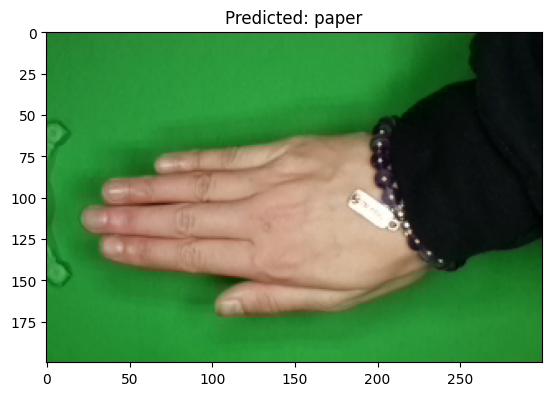

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_image(image_path):
    img = image.load_img(image_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.

    prediction = model.predict(img_tensor)
    predicted_class_index = np.argmax(prediction[0])

    class_names = list(train_generator.class_indices.keys())
    predicted_class = class_names[predicted_class_index]
    return predicted_class

from google.colab import files
uploaded = files.upload()

for filename in uploaded.keys():
    image_path = filename
    predicted_class = predict_image(image_path)
    plt.imshow(plt.imread(image_path))
    plt.title(f"Predicted: {predicted_class}")
    plt.show()
